## Imports

In [3]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer


import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


/opt/anaconda3/envs/otakutag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [7]:
raw_data_path = os.path.join("..","data","cleaned","clean_combined_data.csv")

df = pd.read_csv(raw_data_path)

df.head()

,Title,Synopsis,Action,Adventure,Boys Love,Comedy,Drama,Ecchi,Erotica,Fantasy,Girls Love,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One Punch Man,The seemingly unimpressive Saitama has a rathe...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kimetsu no Yaiba,"Ever since the death of his father, the burden...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Sword Art Online,Ever since the release of the innovative Nerve...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Generate Backup 
df_backup_1 = df.copy()

In [9]:
# Load Backup 
df = df_backup_1.copy()

## Pre-Processing & Tokenization

### Transformer-Based Models (PyTorch + Hugging Face) + ULMFiT (FastAI)
These models use **subword tokenization** (e.g., WordPiece, Byte-Pair Encoding) and are powerful for NLP tasks.

| **Model**              | **Tokenizer** | **Max Tokens** | **Strengths** | **Weaknesses** |
|------------------------|--------------|---------------|--------------|---------------|
| **BERT (bert-base-uncased)** | WordPiece | 512 | General-purpose, bidirectional context, good for sentence-level tasks. | Limited to 512 tokens, slow training. |
| **DistilBERT (distilbert-base-uncased)** | WordPiece | 512 | 40% fewer parameters than BERT, faster inference. | Slightly lower accuracy than BERT. |
| **RoBERTa (roberta-base)** | Byte-Pair Encoding (BPE) | 512 | Trained on more data than BERT, better generalization. | Needs more GPU memory than DistilBERT. |
| **ALBERT (albert-base-v2)** | SentencePiece | 512 | Compressed BERT with shared parameters, faster training. | Some accuracy trade-offs. |
| **XLNet (xlnet-base-cased)** | SentencePiece | 512 | Uses permutation-based learning, good for long sequences. | More complex training, slow inference. |
| **Longformer (allenai/longformer-base-4096)** | Byte-Pair Encoding (BPE) | 4,096 | Handles long documents, sliding window attention. | Expensive to train, high VRAM usage. |
| **GPT-2 (gpt2)** | Byte-Pair Encoding (BPE) | 1,024 | Strong generative capabilities, good for text completion. | Unidirectional, may not work well for classification. |
| **T5 (t5-small)** | SentencePiece | 512 | Can handle multiple NLP tasks (classification, summarization, translation). | Needs task-specific tuning, larger models are VRAM-intensive. |
| **BART (facebook/bart-base)** | Byte-Pair Encoding (BPE) | 1,024 | Seq2Seq-based transformer, good for summarization & text classification. | Requires more computational resources. |
| **ULMFiT (AWD-LSTM - fastai)** | FastAI/Spacy Tokenizer | No fixed limit | Good for small datasets, efficient training. | Not as powerful as transformers, may struggle with unseen words. |

In [ ]:
# Find average and max token length

df_test = df_backup_1.copy()

# Choose tokenizer 
MODEL_NAME = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

token_lengths = df_test["Synopsis"].dropna().apply(lambda x: len(tokenizer.tokenize(x)))

# Compute max and average token lengths
max_length = token_lengths.max()
avg_length = token_lengths.mean()

print(f"Max Token Length: {max_length}")
print(f"Average Token Length: {avg_length}")


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


Max Token Length: 1001
Average Token Length: 103.47926452242773


In [11]:
# We can convert token_lengths to a DataFrame and use the hist method to plot a histogram of the token lengths.
token_df = pd.DataFrame(token_lengths)
token_df.columns = ["Token Length"]
token_df.describe()

,Token Length
count,92185.000000
mean,103.479265
std,77.633858
min,1.000000
25%,39.000000
50%,94.000000
75%,150.000000
max,1001.000000


**Observation:** 

Since 3rd STD value is 150 , safe to say most summaries are short. 

Since there seem to be some outliars , we need to remove them to 

make the df compatible for 512 token based models . 


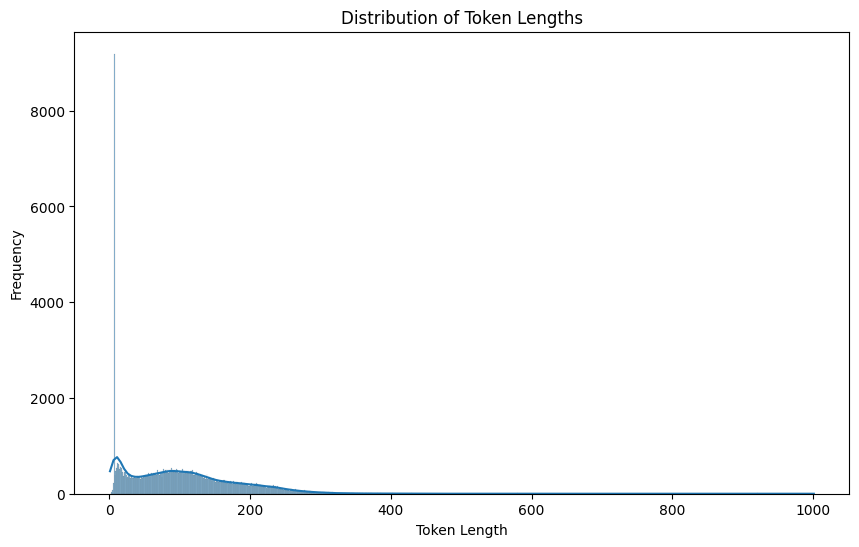

In [12]:
# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
sns.histplot(token_df["Token Length"], bins="auto", kde=True, discrete=True)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()


**Observation:**

It seems like we have a very large peak near 10 . 

It looks unnatural for the kind of work we are doing. 

I need to zoom in a little bit . 

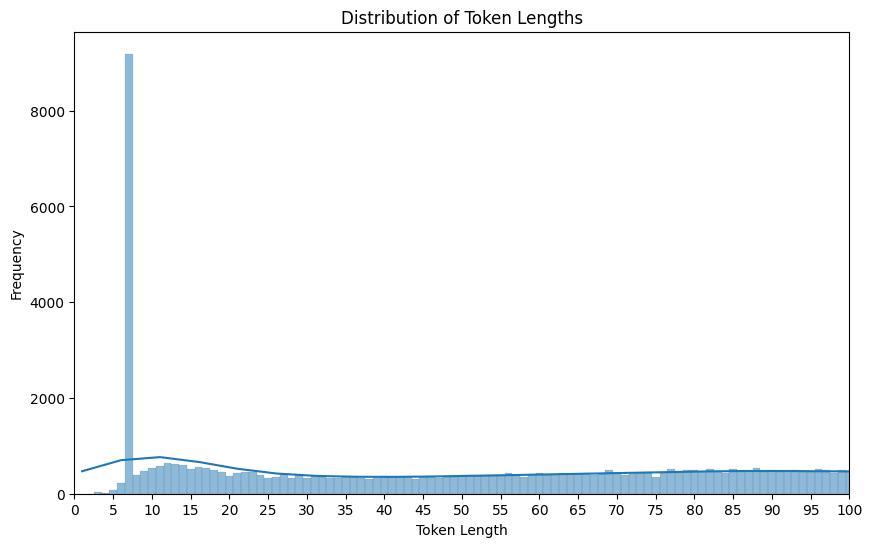

In [ ]:
# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
sns.histplot(token_df["Token Length"], bins="auto", kde=True, discrete=True)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

# Set x-axis limits to zoom in
plt.xlim(0, 100)  

plt.xticks(np.arange(0, 101, 5))  # Adjust the step size as needed

plt.show()


**Observation:**

Looks like the peak is at token size 7 . 

so we need to see what that sentance actually is that is repeating so many times 

In [14]:
# Apply tokenizer to get token lengths and filter rows with exactly 7 tokens
synopsis_with_7_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) == 7)

# Get the original synopses that have exactly 7 tokens
original_synopsis_with_7_tokens = df_test[synopsis_with_7_tokens].copy()

In [15]:
percent_of_sus_data=(original_synopsis_with_7_tokens.shape[0]/(df_test.shape[0]+ original_synopsis_with_7_tokens.shape[0]))*100

print(f"Percentage of data with 7 tokens: {percent_of_sus_data:.2f}%")

Percentage of data with 7 tokens: 8.98%


In [16]:
original_synopsis_with_7_tokens.iloc[:40, :2]

,Title,Synopsis
444,One Punch Man 3,Third season of One Punch Man.
916,Spy x Family Season 3,Third season of Spy x Family.
934,Dandadan 2nd Season,Second season of Dandadan.
995,Shinmai Maou no Testament Departures,(No synopsis yet.)
1033,Overlord Movie 1: Fushisha no Ou,First Overlord recap film.
1038,Strike the Blood IV,Fourth season of Strike the Blood.
1060,Overlord Movie 2: Shikkoku no Eiyuu,Second Overlord recap film.
1354,Break Blade Movie 6: Doukoku no Toride,Sixth and final Break Blade movie.
1559,Cencoroll Connect,The sequel to Cencoroll.
1577,Strike the Blood Final,Fifth season of Strike the Blood.


**Observation:**

From the looks of it,the synopsis with data such as (No Synopsis yet.) and "nth Season of X anime" 

Are of no use for the classification , so we need to find a threshold where the token size indicates

useful synopsis. 

In [17]:
synopsis_with_32_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) == 32)
original_synopsis_with_32_tokens = df_test[synopsis_with_32_tokens].copy()

In [18]:
original_synopsis_with_32_tokens.iloc[:40, :2]

,Title,Synopsis
1052,Chuunibyou demo Koi ga Shitai! Depth of Field:...,Specials bundled with the first season's BD/DV...
1892,Toaru Majutsu no Index-tan Movie: Endymion no ...,Bonus animation featuring Index-tan included w...
2935,All That Gundam,Animated video created just for a 1989 event t...
3028,Kyoukaisenjou no Horizon Special,The Blu-ray Box set of Kyoukaisenjou no Horizo...
3061,Cobra The Animation: Time Drive,Lady has disappeared so Cobra must dive into h...
3269,Ku Pao Ying Xiong,The animation tells the story of Xiao Shuai wh...
3289,Bari Bari Densetsu (1987),The film is about 4 high-schoolers who are bik...
3431,Super Robot Taisen OG: Divine Wars - Sorezore ...,This is considered episode 26 of the series wh...
3650,Aru Zombie Shoujo no Sainan PV,Promotional video for an anime adaptation of t...
3775,Kung Fu Liaoli Niang,"A young, starving traveler finds himself in th..."


In [19]:
synopsis_with_less_than_32_tokens = df_test["Synopsis"].apply(lambda x: len(tokenizer.tokenize(str(x))) < 31)
original_synopsis_with_less_than_32_tokens = df_test[synopsis_with_less_than_32_tokens].copy()

percent_less_than_32_token=(original_synopsis_with_less_than_32_tokens.shape[0]/(df_test.shape[0]+ original_synopsis_with_less_than_32_tokens.shape[0]))*100

print(f"Original data size: {df_test.shape[0]}")
print(f"Data size with less than 31 tokens: {original_synopsis_with_less_than_32_tokens.shape[0]}")
print(f"Percentage of data with less than 31 tokens: {percent_less_than_32_token:.2f}%")
print(f"Total data size after filtering: {df_test.shape[0] - original_synopsis_with_less_than_32_tokens.shape[0]}")

Original data size: 93144
Data size with less than 31 tokens: 21151
Percentage of data with less than 31 tokens: 18.51%
Total data size after filtering: 71993


71,993 is still plenty of data for our task. 

**Observation:**

Token size of 32 and above seems to contain synopsis with useful information 

for classification . So we will only keep the data that is greater or equal 

to 32 tokens and less than or equal to 512 tokens. 

In [ ]:
MAX_TOKENS = 512
MIN_TOKENS = 32

# Function to safely tokenize and handle non-strings
def get_token_length(text):
    try:
        return len(tokenizer.tokenize(str(text)))
    except Exception as e:
        print(f"Error tokenizing text: {text}, {e}")
        return 0 

# Compute token lengths for all "Synopsis" entries, ensuring non-null values
mask = df["Synopsis"].notna() & (df["Synopsis"].apply(get_token_length) <= MAX_TOKENS) & (df["Synopsis"].apply(get_token_length) >= MIN_TOKENS)

# Filter rows where the token length is within the min and max limits
df_filtered_tokens = df[mask].copy()  # Avoids SettingWithCopyWarning

# Print summary
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered_tokens)}")

Original dataset size: 93144
Filtered dataset size: 71548


In [21]:
df_filtered_tokens.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71548 entries, 0 to 92196
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          71548 non-null  object 
 1   Synopsis       71548 non-null  object 
 2   Action         70904 non-null  float64
 3   Adventure      70904 non-null  float64
 4   Boys Love      70904 non-null  float64
 5   Comedy         70904 non-null  float64
 6   Drama          70904 non-null  float64
 7   Ecchi          70904 non-null  float64
 8   Erotica        70904 non-null  float64
 9   Fantasy        70904 non-null  float64
 10  Girls Love     70904 non-null  float64
 11  Horror         70904 non-null  float64
 12  Mystery        70904 non-null  float64
 13  Romance        70904 non-null  float64
 14  Sci-Fi         70904 non-null  float64
 15  Slice of Life  70904 non-null  float64
 16  Sports         70904 non-null  float64
 17  Supernatural   70904 non-null  float64
 18  Suspense   

**Observation:**

From the looks of it, there are rows with empty target values i.e. genre value .

So we need to drop those now . 

In [ ]:
# # List of genre columns
# genre_columns = [
#     "Action", "Adventure", "Boys Love", "Comedy", "Drama", "Ecchi", 
#     "Erotica", "Fantasy", "Girls Love", "Horror", "Mystery", 
#     "Romance", "Sci-Fi", "Slice of Life", "Sports", "Supernatural", "Suspense"
# ]

# # Drop rows where all genre columns are null
# df_cleaned = df_filtered_tokens.dropna(subset=genre_columns, how='all')

# # Check the result
# print(f"Previous dataset size: {len(df_filtered_tokens)}")
# print(f"Cleaned dataset size (after dropping rows with all genre nulls): {len(df_cleaned)}")

Previous dataset size: 71548
Cleaned dataset size (after dropping rows with all genre nulls): 70904


In [ ]:
# List of genre columns
genre_columns = [
    "Action", "Adventure", "Boys Love", "Comedy", "Drama", "Ecchi", 
    "Erotica", "Fantasy", "Girls Love", "Horror", "Mystery", 
    "Romance", "Sci-Fi", "Slice of Life", "Sports", "Supernatural", "Suspense"
]

remove_columns = ["Girls Love", "Ecchi", "Erotica", "Boys Love"]

df_cleaned = df_filtered_tokens.drop(columns=remove_columns)

# Dropping rows where all genre columns are null

filtered_genere = [col for col in genre_columns if col not in remove_columns]

df_cleaned = df_cleaned.dropna(subset=filtered_genere, how='all')

print(f"Previous dataset size: {len(df_filtered_tokens)}")
print(f"Cleaned dataset size (after dropping unwanted columns and rows with all genre nulls): {len(df_cleaned)}")

Previous dataset size: 71548
Cleaned dataset size (after dropping unwanted columns and rows with all genre nulls): 70904


In [24]:
genre_columns = filtered_genere

In [25]:
print(df_cleaned.head())
df_cleaned.info()

                              Title  \
0                Shingeki no Kyojin   
1  Fullmetal Alchemist: Brotherhood   
2                     One Punch Man   
3                  Kimetsu no Yaiba   
4                  Sword Art Online   

                                            Synopsis  Action  Adventure  \
0  Centuries ago, mankind was slaughtered to near...     1.0        0.0   
1  After a horrific alchemy experiment goes wrong...     1.0        1.0   
2  The seemingly unimpressive Saitama has a rathe...     1.0        0.0   
3  Ever since the death of his father, the burden...     1.0        0.0   
4  Ever since the release of the innovative Nerve...     1.0        1.0   

   Comedy  Drama  Fantasy  Horror  Mystery  Romance  Sci-Fi  Slice of Life  \
0     0.0    1.0      0.0     0.0      0.0      0.0     0.0            0.0   
1     0.0    1.0      1.0     0.0      0.0      0.0     0.0            0.0   
2     1.0    0.0      0.0     0.0      0.0      0.0     0.0            0.0   
3 

Let's see the status of our Generes after the final touch up with our data . 

Based on these values, we need to decide and select various data samplaing and training 

techniques to confonsate for the imbalance of data.   

In [26]:
genre_columns = df_cleaned.columns[2:] 

genre_counts = df_cleaned[genre_columns].sum()

genre_counts = genre_counts.sort_values(ascending=False)

print(genre_counts)

df_cleaned.head()

Action           23830.0
Comedy           23174.0
Fantasy          22237.0
Romance          17996.0
Drama            17720.0
Adventure        15923.0
Supernatural     12399.0
Sci-Fi           12166.0
Slice of Life     7502.0
Mystery           6600.0
Horror            4068.0
Suspense          1996.0
Sports            1663.0
dtype: float64


,Title,Synopsis,Action,Adventure,Comedy,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,Shingeki no Kyojin,"Centuries ago, mankind was slaughtered to near...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,One Punch Man,The seemingly unimpressive Saitama has a rathe...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Kimetsu no Yaiba,"Ever since the death of his father, the burden...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Sword Art Online,Ever since the release of the innovative Nerve...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Model Training  

| **Model**                | **Size**            | **Speed**                   | **Memory Requirements**  | **Reason to Choose** | **Why Not** |
|--------------------------|---------------------|-----------------------------|--------------------------|----------------------|-------------|
| **BERT (bert-base-uncased)** | Medium (110M parameters) | Slow to moderate           | High (~12GB for fine-tuning) | Popular, well-supported for classification tasks | High memory requirements for training |
| **DistilBERT (distilbert-base-uncased)** | Smaller (66M parameters) | Faster than BERT           | Moderate (~8GB for fine-tuning) | Faster and lighter version of BERT, good for resource-constrained setups | Slightly lower accuracy than full BERT |
| **RoBERTa (roberta-base)** | Large (125M parameters) | Slow to moderate           | High (~13GB for fine-tuning) | Improved BERT architecture, good for NLP tasks | High memory usage, slower processing |
| **ALBERT (albert-base-v2)** | Small (12M parameters) | Fast                       | Low (~5GB for fine-tuning)  | Efficient, reduces model size, still effective for NLP | Somewhat lower accuracy compared to BERT and RoBERTa |
| **XLNet (xlnet-base-cased)** | Large (110M parameters) | Slow to moderate           | High (~12GB for fine-tuning) | Great for NLP tasks, powerful but complex | Higher memory usage, slower inference |
| **Longformer (allenai/longformer-base-4096)** | Large (125M parameters) | Moderate                   | High (~12GB for fine-tuning) | Best for long sequences (large token window) | Not ideal for short data (like 512 tokens max) |
| **GPT-2 (gpt2)** | Large (124M parameters) | Moderate                   | High (~12GB for fine-tuning) | Good for generative tasks, less suited for classification | Not designed for classification, slower for non-generative tasks |
| **T5 (t5-small)** | Small (60M parameters) | Moderate                   | Moderate (~8GB for fine-tuning) | Good for text generation and translation tasks, flexible | Not as optimized for classification tasks |
| **BART (facebook/bart-base)** | Large (140M parameters) | Moderate                   | High (~13GB for fine-tuning) | Good for sequence-to-sequence tasks, robust for text generation | High memory usage, slower inference |
| **ULMFiT (AWD-LSTM - fastai)** | Medium (50M parameters) | Fast                       | Moderate (~8GB for fine-tuning) | Works well with transfer learning, fast training, optimized for smaller datasets | May not perform as well as transformer-based models |

Recommended Models for my system:

1. **DistilBERT**:
   - **Why**: It’s a smaller, faster, and more memory-efficient version of BERT with nearly the same performance. Given our data (70K samples, 512 tokens), it will balance speed and performance on our system well.

2. **ALBERT**:
   - **Why**: ALBERT’s architecture is more efficient, requiring less memory while maintaining good performance. It is ideal for my MacBook with 24GB of RAM, especially if we're looking for faster training.

3. **T5 (t5-small)**:
   - **Why**: It’s smaller and more efficient, suitable for text generation and classification tasks. It will run well on our setup with moderate memory consumption.

**Avoid/Consider for Larger Models**:

- **BERT, RoBERTa, XLNet, BART**:
  - **Why Not**: These models are more resource-heavy and would require significant GPU/CPU power and memory for fine-tuning, which may cause slower processing times on our system. If memory is an issue, these models might be a challenge for training with our data size.

### Data Sampling techniques 

The probelm we are solving is multi-label classification . 

The data that we have, even after cleain is not perfect . 

So we need to take help of statistical decision making to aid 

the model steer into the direction we want it to take . 

#### **Which Model Techniques We Need and Why?**  

| **Technique**                                      | **Needed?** | **Why?**  |
|----------------------------------------------------|------------|----------|
| **1. Weighted Binary Cross-Entropy Loss**         | ✅ Yes     | We have some imbalanced genres (e.g., **Suspense (1996)** vs. **Action (23830)**). Without weighting, the model might focus too much on frequent genres, ignoring rare ones. Weighted BCE ensures minority labels contribute fairly to the loss.  |
| **2. Focal Loss**                                  | ❌ No      | Our dataset isn't extremely imbalanced. Focal Loss is useful when **minority labels are extremely rare (e.g., <1% of total data)**, which isn't the case here. Weighted BCE should be enough.  |
| **3. Threshold Tuning for Multi-Label Classification** | ✅ Yes     | Since multi-label classification isn't a simple "highest probability wins" problem, setting the right threshold per genre is **critical** to avoid over/under-predicting labels. This improves the F1-score. |

---

### **Sampling Techniques (During Training)**  

| **Technique**                                      | **Needed?** | **Why?**  |
|----------------------------------------------------|------------|----------|
| **1. Stratified Sampling**                         | ✅ Yes     | If we train in **random batches**, some batches may lack rare genres. Stratified sampling ensures each batch contains diverse labels, helping the model learn from underrepresented genres.  |
| **2. MixUp / CutMix Augmentation**                | ❌ No      | These techniques are **more suited for vision tasks** (e.g., images). In text, mixing two different synopses could confuse the model rather than help it learn meaningful genre relationships. |

### **Final Conclusion**:
✅ Use **Weighted BCE Loss**  
✅ Apply **Threshold Tuning**  
✅ Implement **Stratified Sampling**  

This setup ensures our model fairly learns all genres while handling class imbalance effectively! 🚀

Pipeline Order:

1️⃣ Stratified Sampling 

2️⃣ Tokenization & Dataloader Creation 

3️⃣ Model Training with BCE Loss (After Tokenization)

4️⃣ Threshold Tuning (After Model Training)

#### Stratified Sampling (Before Training)

Ensures each batch has a balanced proportion of majority & minority genres.

	•	Since this is multi-label classification, traditional stratified sampling won’t work directly.
	
	•	Instead, use “Multi-label Stratified Sampling” from iterative-stratification package.

In [ ]:
#  Straified Tranin Test Split Creation

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Extract features & labels
X = df_cleaned["Synopsis"].values  # Summary
y = df_cleaned.iloc[:, 2:].values  # All genre columns

# Define Stratified K-Fold
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in mskf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    

In [28]:

# Convert to DataFrames
df_train = pd.DataFrame({'Synopsis': X_train, 'Genres': list(y_train)})
df_val = pd.DataFrame({'Synopsis': X_val, 'Genres': list(y_val)})

In [29]:
df_train.shape, df_val.shape

((56723, 2), (14181, 2))

In [30]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14181 entries, 0 to 14180
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Synopsis  14181 non-null  object
 1   Genres    14181 non-null  object
dtypes: object(2)
memory usage: 221.7+ KB


In [ ]:
genre_columns = df_cleaned.columns[2:]  

# Convert to DataFrames and select the correct genre columns
df_train = pd.DataFrame({'Synopsis': X_train, **dict(zip(genre_columns, y_train.T))})
df_val = pd.DataFrame({'Synopsis': X_val, **dict(zip(genre_columns, y_val.T))})

In [32]:
df_train.head()

,Synopsis,Action,Adventure,Comedy,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,"Centuries ago, mankind was slaughtered to near...",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"Ever since the death of his father, the burden...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Ever since the release of the innovative Nerve...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,"The appearance of ""quirks,"" newly discovered s...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hunters devote themselves to accomplishing haz...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### DataLoader and Tokenization (DistilBERT)

In [ ]:
# DistilBERT Tokenization and PyTorch Dataset Creation
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast


MAX_LENGTH = 512

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
genre_columns = df_cleaned.columns[2:]  

# Custom PyTorch Dataset to handle tokenization and label conversion
class AnimeDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        """
        Args:
        - df: Pandas DataFrame containing "Synopsis" and genre labels.
        - tokenizer: Tokenizer (DistilBERT in this case).
        - max_length: Maximum token length (512 for BERT-like models).
        """
        self.df = df.copy()  
        self.tokenizer = tokenizer  
        self.max_length = max_length  

        # Ensure genre columns are numeric (convert and fill NaN with 0)
        self.df[genre_columns] = self.df[genre_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """Returns a tokenized sample and its corresponding labels."""
        row = self.df.iloc[idx]  
        
        # Tokenize the Synopsis column value
        encoding = self.tokenizer(
            row["Synopsis"],  
            padding="max_length",  # Pad all sequences to the max length
            truncation=True,  # Truncate if input is longer than max_length
            max_length=self.max_length,  # Set max token length
            return_tensors="pt"  # Return PyTorch tensors
        )

        # Convert genre labels to a tensor (multi-label classification)
        labels = torch.tensor(row[genre_columns].values.astype(float), dtype=torch.float)
        """
        Input id's are essentially the tokenization mapping id. 
        Attention mask helps distinguish the paddings. 
        """
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Tokenized input IDs
            "attention_mask": encoding["attention_mask"].squeeze(0),  # Attention mask
            "labels": labels  # Multi-label target vector
        }

# Create dataset instances for training and validation
train_dataset = AnimeDataset(df_train, tokenizer, MAX_LENGTH)
val_dataset = AnimeDataset(df_val, tokenizer, MAX_LENGTH)

# Create DataLoaders for batching and shuffling data
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle for randomness
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)  # No shuffle for validation

# Fetch and inspect a single batch to verify shape
batch = next(iter(train_loader))
print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)

torch.Size([8, 512]) torch.Size([8, 512]) torch.Size([8, 13])


#### Model Training (DistilBERT) 

In [ ]:
# without gradient accumulation 

import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import numpy as np
import os

# Use MPS if available on Mac, otherwise use CUDA if available, else CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_labels = 13

# Load pre-trained DistilBERT model 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)
model.to(device)

# ---------------------------
# Compute Class Weights for Weighted BCE Loss
# ---------------------------
all_labels = []
for batch in train_loader:
    all_labels.append(batch["labels"].to(device).cpu().numpy())
all_labels = np.concatenate(all_labels, axis=0)
class_counts = np.sum(all_labels, axis=0)
pos_weight = (len(all_labels) - class_counts) / (class_counts + 5e-6)
pos_weight = torch.tensor(pos_weight, dtype=torch.float, device=device)

# Define Weighted BCE Loss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ---------------------------
# Optimizer & Scheduler
# ---------------------------

"""

A Learning Rate Scheduler adjusts the learning rate during training. 
It is typically used to decrease the learning rate over time to help the model converge smoothly. 
It allows the model to start with a larger learning rate 
(so it can make large updates to the weights in the beginning) and 
then reduce the learning rate (so it can make smaller, more refined updates as training progresses).

The function get_linear_schedule_with_warmup is a type of learning rate scheduler 
that uses linear decay with a warmup period. This means:
	•	The learning rate starts from a small value (warmup).
	•	It gradually increases to a predefined value (typically the original learning rate) 
        during the warmup phase.
	•	After the warmup period, the learning rate decreases linearly towards 0.
 
 """


optimizer = AdamW(model.parameters(), lr=5e-6)

num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=int(0.1 * total_steps), 
                                            num_training_steps=total_steps)



# ---------------------------
# Save and Load Checkpoint
# ---------------------------
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save model, optimizer, and scheduler state
def save_checkpoint(epoch, model, optimizer, scheduler, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Function to load model, optimizer, and scheduler state
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

# Try to load checkpoint if exists
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
start_epoch = 0
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(f"Resuming training from epoch {start_epoch + 1}.")

# ---------------------------
# Training Loop
# ---------------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    print(f"Starting Epoch {epoch+1}/{num_epochs}...")
    for step, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()  # Reset gradients

        # Move batch data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass: get raw logits
        outputs = model(input_ids, attention_mask=attention_mask, labels=None)
        # Labels = None because we want to update the weights based on our optimization function
        logits = outputs.logits  # shape: [batch_size, num_labels]
        """
        Logits are the raw, unnormalized output values 
        produced by the model’s final layer before applying an activation function 
        """
        # Compute weighted BCE loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()  # Reset gradients after updating weights

        # Save checkpoint every 100 steps
        if step % 100 == 0:
            save_checkpoint(epoch+1, model, optimizer, scheduler, total_loss / step, checkpoint_path)
            print(f"Checkpoint saved at step {step}.")

        if step % 10 == 0:  # Print every 10 steps
            print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_loss:.4f}")

    # Save checkpoint at the end of each epoch
    save_checkpoint(epoch+1, model, optimizer, scheduler, avg_loss, checkpoint_path)

    # ---------------------------
    # Validation Loop (Optional)
    # ---------------------------
    model.eval()
    
    """
    model.eval(): This sets the model to evaluation mode. 
                  It is important for certain layers like dropout and batch normalization, 
                  which behave differently during training and evaluation. 
                  In evaluation mode, dropout is turned off, and 
                  batch normalization uses running statistics instead of batch statistics.
    
    """
    
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=None)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_val_loss:.4f}")

print("Training complete!")

SyntaxError: incomplete input (411494913.py, line 155)

In [85]:
# Load the model with the checkpoint

import torch
from transformers import DistilBertForSequenceClassification

# Use MPS if available on Mac, otherwise use CUDA if available, else CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

checkpoint_path = 'checkpoints/checkpoint.pth'
num_labels = 13

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)

# Load the model state dict
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Move model to the correct device (e.g., GPU or CPU)
model.to(device)

# If you need to use the model for inference now, it's ready!

Using device: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/83/np7cbr6j13x9w73whgdqvldw0000gn/T/ipykernel_79385/3921872245.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Threshold Tuning

Now we will try to find an activation threshold for each label 

for which the F1 score is maximum . 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score

def find_best_thresholds(model, dataloader, device, threshold_range=np.arange(0.1, 1.0, 0.1)):
    """
    Finds the best threshold for each label to maximize the F1-score.
    
    Args:
        model: Trained multi-label classification model.
        dataloader: Validation/test DataLoader.
        device: Device (cuda or cpu).
        threshold_range: Range of threshold values to search.

    Returns:
        best_thresholds: Dictionary with optimal thresholds per class.
    """
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()  # True labels

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities

            all_labels.append(labels)
            all_probs.append(probs)

    all_labels = np.vstack(all_labels)  # Shape: (num_samples, num_classes)
    all_probs = np.vstack(all_probs)  # Shape: (num_samples, num_classes)

    num_classes = all_labels.shape[1]
    best_thresholds = {}

    # Iterate over each class
    for i in range(num_classes):
        best_f1 = 0
        best_thresh = 0.5  # Default threshold
        
        # Search for best threshold in the range
        for threshold in threshold_range:
            preds = (all_probs[:, i] >= threshold).astype(int)  # Apply threshold
            f1 = f1_score(all_labels[:, i], preds, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = threshold
        
        best_thresholds[i] = best_thresh  # Store best threshold for this class
        print(f"Label {i}: Best Threshold = {best_thresh:.2f}, Best F1-score = {best_f1:.4f}")

    return best_thresholds

# Run threshold tuning on validation data
best_thresholds = find_best_thresholds(model, val_loader, device)

Label 0: Best Threshold = 0.40, Best F1-score = 0.5623
Label 1: Best Threshold = 0.50, Best F1-score = 0.4793
Label 2: Best Threshold = 0.40, Best F1-score = 0.4998
Label 3: Best Threshold = 0.40, Best F1-score = 0.4149
Label 4: Best Threshold = 0.50, Best F1-score = 0.5415
Label 5: Best Threshold = 0.70, Best F1-score = 0.2135
Label 6: Best Threshold = 0.70, Best F1-score = 0.2980
Label 7: Best Threshold = 0.40, Best F1-score = 0.4427
Label 8: Best Threshold = 0.60, Best F1-score = 0.4662
Label 9: Best Threshold = 0.60, Best F1-score = 0.2936
Label 10: Best Threshold = 0.80, Best F1-score = 0.1797
Label 11: Best Threshold = 0.50, Best F1-score = 0.3917
Label 12: Best Threshold = 0.70, Best F1-score = 0.1040


In [ ]:
# Apply thresholds to the model predicitons 

def apply_thresholds(logits, best_thresholds):
    """
    Apply optimized thresholds to model predictions.

    Args:
        logits: Raw model outputs (logits).
        best_thresholds: Dictionary of optimal thresholds per class.

    Returns:
        Binary predictions (0 or 1) for each label.
    """
    # Apply sigmoid to logits to get probabilities
    probs = torch.sigmoid(logits).detach().to(device).cpu().numpy()
    preds = np.zeros_like(probs)  
    
    # Iterate over classes to apply the best threshold for each
    for i in range(probs.shape[1]):  
        preds[:, i] = (probs[:, i] >= best_thresholds[i]).astype(int)

    return 


logits = model(input_ids, attention_mask=attention_mask).logits

best_predictions = apply_thresholds(logits, best_thresholds)

# Now best_predictions contains the binary predictions (0 or 1) based on the best thresholds.

In [35]:
import torch
import numpy as np
from sklearn.metrics import classification_report

best_thresholds = [0.40, 0.50, 0.40, 0.40, 0.50, 0.70, 0.70, 0.40, 0.60, 0.60, 0.80, 0.50, 0.70]

# Define optimized thresholds per genre
thresholds = {
    "Action": 0.40, "Adventure": 0.50, "Comedy": 0.40, "Drama": 0.40, "Fantasy": 0.50,
    "Horror": 0.70, "Mystery": 0.70, "Romance": 0.40, "Sci-Fi": 0.60, "Slice of Life": 0.60,
    "Sports": 0.80, "Supernatural": 0.50, "Suspense": 0.70
}

# Convert thresholds to tensor (for batch processing)
thresholds_tensor = torch.tensor(list(thresholds.values())).to(device)

def evaluate_model(model, dataloader):
    """Evaluates the model on the validation set using optimized thresholds."""
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=None)
            logits = outputs.logits  # Raw predictions

            # Apply sigmoid activation (converts logits to probabilities)
            probs = torch.sigmoid(logits)

            # Apply optimized thresholds
            preds = (probs > thresholds_tensor).int()  # Convert to binary predictions

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Calculate evaluation metrics
    report = classification_report(all_labels, all_preds, target_names=thresholds.keys(), digits=4)
    print(report)

# Run evaluation
evaluate_model(model, val_loader)

               precision    recall  f1-score   support

       Action     0.4363    0.7908    0.5623      4766
    Adventure     0.3704    0.6791    0.4793      3185
       Comedy     0.3588    0.8233    0.4998      4635
        Drama     0.2734    0.8600    0.4149      3544
      Fantasy     0.5222    0.5622    0.5415      4447
       Horror     0.1453    0.4029    0.2135       814
      Mystery     0.2359    0.4045    0.2980      1320
      Romance     0.3088    0.7816    0.4427      3599
       Sci-Fi     0.4565    0.4764    0.4662      2433
Slice of Life     0.2164    0.4564    0.2936      1501
       Sports     0.1280    0.3012    0.1797       332
 Supernatural     0.2898    0.6040    0.3917      2480
     Suspense     0.0619    0.3258    0.1040       399

    micro avg     0.3294    0.6738    0.4425     33455
    macro avg     0.2926    0.5745    0.3759     33455
 weighted avg     0.3580    0.6738    0.4546     33455
  samples avg     0.3407    0.6677    0.4270     33455



/opt/anaconda3/envs/otakutag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Understanding Classification Metrics**

When evaluating a classification model, we use these key metrics:

- **Precision**: Out of all the predictions for a genre, how many were actually correct? (Lower means more false positives.)
- **Recall**: Out of all the actual instances of a genre, how many did the model correctly identify? (Lower means more false negatives.)
- **F1-Score**: A balance between precision and recall. Higher is better.
- **Support**: The number of actual examples for that genre in the dataset.

**Averages:**
- **Micro Avg**: Treats all genre predictions equally.
- **Macro Avg**: Averages across all genres, regardless of size.
- **Weighted Avg**: Like macro, but accounts for genre sizes.
- **Samples Avg**: Evaluates across multiple labels per sample.

Higher values usually mean better performance!

**DistilRoberta Weight Thresholld Optimized Performance**

| Genre            | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| Action         | 0.4363    | 0.7908 | 0.5623   | 4766    |
| Adventure      | 0.3704    | 0.6791 | 0.4793   | 3185    |
| Comedy        | 0.3588    | 0.8233 | 0.4998   | 4635    |
| Drama         | 0.2734    | 0.8600 | 0.4149   | 3544    |
| Fantasy       | 0.5222    | 0.5622 | 0.5415   | 4447    |
| Horror        | 0.1453    | 0.4029 | 0.2135   | 814     |
| Mystery       | 0.2359    | 0.4045 | 0.2980   | 1320    |
| Romance       | 0.3088    | 0.7816 | 0.4427   | 3599    |
| Sci-Fi        | 0.4565    | 0.4764 | 0.4662   | 2433    |
| Slice of Life | 0.2164    | 0.4564 | 0.2936   | 1501    |
| Sports        | 0.1280    | 0.3012 | 0.1797   | 332     |
| Supernatural  | 0.2898    | 0.6040 | 0.3917   | 2480    |
| Suspense      | 0.0619    | 0.3258 | 0.1040   | 399     |
| **Micro Avg**  | 0.3294    | 0.6738 | 0.4425   | 33455   |
| **Macro Avg**  | 0.2926    | 0.5745 | 0.3759   | 33455   |
| **Weighted Avg** | 0.3580 | 0.6738 | 0.4546   | 33455   |
| **Samples Avg**  | 0.3407 | 0.6677 | 0.4270   | 33455   |



In [ ]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
}, '../models/distilroberta_model_with_thresholds.pth')

# Save thresholds to a separate file
torch.save(thresholds_tensor, '../models/thresholds_tensor.pth')

In [ ]:
# Load the model 

model.load_state_dict(torch.load('../models/distilroberta_model_with_thresholds.pth')['model_state_dict'])

# Load the thresholds

thresholds_tensor = torch.load('../models/thresholds_tensor.pth').to(device)


/var/folders/83/np7cbr6j13x9w73whgdqvldw0000gn/T/ipykernel_79385/1654219762.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('distilrober

In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

def get_predicted_genres(descriptions, model, tokenizer, thresholds_tensor, device='mps'):
    """
    Given a list of anime descriptions, this function predicts the genres using a pre-trained model
    and applies individual thresholds for each genre.

    Parameters:
    - descriptions: List of strings (anime descriptions).
    - model: Pre-trained model for sequence classification.
    - tokenizer: Tokenizer corresponding to the model.
    - thresholds_tensor: Tensor of thresholds for each genre (shape should be [num_labels]).
    - device: Device to run the model on ('cpu', 'cuda', or 'mps').

    Returns:
    - A list of predicted genres for each description.
    """
    model.eval()

    inputs = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probs = torch.sigmoid(logits)

    predictions = (probs > thresholds_tensor).int()

    genre_labels = ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense']

    result = []
    for i, description in enumerate(descriptions):
        predicted_genres = [genre_labels[j] for j in range(len(genre_labels)) if predictions[i][j] == 1]
        result.append({
            "description": description,
            "predicted_genres": predicted_genres
        })
    
    return result

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=13).to(device)
model.load_state_dict(torch.load('distilroberta_model_with_thresholds.pth')['model_state_dict'])

test_descriptions = [
    "A young warrior embarks on a quest to defeat monsters and save the world.",
    "A high school romance story set in a quiet town filled with mysterious events.",
    "A group of heroes fight against a dark force threatening the universe.",
    "A slice-of-life anime following the daily lives of a group of friends in school.",
    "A science fiction adventure set in a futuristic world with AI and robots.",
    "A lovely boy falls in a pit of doom and has to abandon his love for the sake of becoming a vampire."
]

results = get_predicted_genres(test_descriptions, model, tokenizer, thresholds_tensor)

for result in results:
    print(f"Description: {result['description']}")
    print(f"Predicted Genres: {', '.join(result['predicted_genres'])}")
    print("-" * 50)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/83/np7cbr6j13x9w73whgdqvldw0000gn/T/ipykernel_79385/1342940742.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

Description: A young warrior embarks on a quest to defeat monsters and save the world.
Predicted Genres: Action, Adventure, Fantasy
--------------------------------------------------
Description: A high school romance story set in a quiet town filled with mysterious events.
Predicted Genres: Drama, Mystery, Romance, Slice of Life, Supernatural
--------------------------------------------------
Description: A group of heroes fight against a dark force threatening the universe.
Predicted Genres: Action, Adventure, Fantasy, Sci-Fi
--------------------------------------------------
Description: A slice-of-life anime following the daily lives of a group of friends in school.
Predicted Genres: Comedy, Drama, Romance, Slice of Life, Sports
--------------------------------------------------
Description: A science fiction adventure set in a futuristic world with AI and robots.
Predicted Genres: Action, Adventure, Sci-Fi
--------------------------------------------------
Description: A lovely bo

---

### Convert to ONNX

In [ ]:
import torch
import torch.onnx
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Example input (this should be a single sample, matching your batch size and input format)
# Modify this part to match the expected input shape for your model
example_input = torch.randint(0, 1000, (1, 512)).to(device)  # Example: Batch size 1, sequence length 512

# Path where you want to save the ONNX model
onnx_model_path = '../models/distilroberta_model_with_thresholds.onnx'

# Export the model to ONNX format
torch.onnx.export(
    model,  # Model to be exported
    example_input,  # Example input to trace the model
    onnx_model_path,  # Path to save the ONNX model
    input_names=["input_ids"],  # Name of the input tensor
    output_names=["logits"],  # Name of the output tensor
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},  # Dynamic axes for batch size and sequence length
        "logits": {0: "batch_size"}  # Dynamic axes for output (logits)
    },
    opset_version=17  # ONNX opset version 
)

print(f"Model has been converted to ONNX and saved at {onnx_model_path}")

Model has been converted to ONNX and saved at distilroberta_model_with_thresholds.onnx


In [ ]:
# Load the ONNX model using ONNX Runtime or similar
import onnx
import onnxruntime as ort

# Load the ONNX model
onnx_model = onnx.load('../models/distilroberta_model_with_thresholds.onnx')
onnx.checker.check_model(onnx_model)  # Check model's validity

# Create a session with ONNX Runtime
onnx_session = ort.InferenceSession('distilroberta_model_with_thresholds.onnx')

# Load the thresholds from a separate file
thresholds_tensor = torch.load('thresholds_tensor.pth').to(device)

# Now you can apply the thresholds after getting the predictions from the ONNX model

/var/folders/83/np7cbr6j13x9w73whgdqvldw0000gn/T/ipykernel_79385/1548981088.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thresholds_tensor = torch.load('thresholds_t

In [ ]:
import torch
import numpy as np
import onnxruntime as ort
from sklearn.metrics import classification_report

def evaluate_model(onnx_session, dataloader, thresholds_tensor):
    """Evaluates the ONNX model on the validation set using optimized thresholds."""
    all_labels = []
    all_preds = []

    # Loop through the dataloader
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
      #  attention_mask = batch["attention_mask"].to(device)  # Corrected to attention_mask
        labels = batch["labels"].to(device)

        # Prepare input for ONNX model
        input_feed = {
            "input_ids": input_ids.cpu().numpy(),
          #  "attention_mask": attention_mask.cpu().numpy()  # Corrected to attention_mask
        }

        # Forward pass with ONNX Runtime
        onnx_output = onnx_session.run(None, input_feed)
        logits = torch.tensor(onnx_output[0]).to(device)  # Convert ONNX output to tensor

        # Apply sigmoid activation (converts logits to probabilities)
        probs = torch.sigmoid(logits)

        # Apply optimized thresholds
        preds = (probs > thresholds_tensor).int()  # Convert to binary predictions

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Calculate evaluation metrics
    report = classification_report(all_labels, all_preds, target_names=thresholds.keys(), digits=4)
    print(report)

# Run evaluation
evaluate_model(onnx_session, val_loader, thresholds_tensor)

               precision    recall  f1-score   support

       Action     0.3547    0.9648    0.5187      4766
    Adventure     0.4290    0.2581    0.3223      3185
       Comedy     0.3269    0.9998    0.4927      4635
        Drama     0.2502    0.9994    0.4003      3544
      Fantasy     0.5410    0.3101    0.3942      4447
       Horror     0.1901    0.0663    0.0984       814
      Mystery     0.3180    0.0682    0.1123      1320
      Romance     0.2541    1.0000    0.4053      3599
       Sci-Fi     0.6132    0.1603    0.2542      2433
Slice of Life     0.2222    0.0080    0.0154      1501
       Sports     0.1875    0.0090    0.0172       332
 Supernatural     0.1824    0.9649    0.3069      2480
     Suspense     0.0459    0.0226    0.0303       399

    micro avg     0.2889    0.6434    0.3988     33455
    macro avg     0.3012    0.4486    0.2591     33455
 weighted avg     0.3501    0.6434    0.3605     33455
  samples avg     0.2872    0.6200    0.3757     33455



/opt/anaconda3/envs/otakutag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ONNX Classification Report

| Genre            | Precision | Recall | F1-Score | Support |
|-----------------|-----------|--------|----------|---------|
| Action         | 0.3547    | 0.9648 | 0.5187   | 4766    |
| Adventure      | 0.4290    | 0.2581 | 0.3223   | 3185    |
| Comedy        | 0.3269    | 0.9998 | 0.4927   | 4635    |
| Drama         | 0.2502    | 0.9994 | 0.4003   | 3544    |
| Fantasy       | 0.5410    | 0.3101 | 0.3942   | 4447    |
| Horror        | 0.1901    | 0.0663 | 0.0984   | 814     |
| Mystery       | 0.3180    | 0.0682 | 0.1123   | 1320    |
| Romance       | 0.2541    | 1.0000 | 0.4053   | 3599    |
| Sci-Fi        | 0.6132    | 0.1603 | 0.2542   | 2433    |
| Slice of Life | 0.2222    | 0.0080 | 0.0154   | 1501    |
| Sports        | 0.1875    | 0.0090 | 0.0172   | 332     |
| Supernatural  | 0.1824    | 0.9649 | 0.3069   | 2480    |
| Suspense      | 0.0459    | 0.0226 | 0.0303   | 399     |
| **Micro Avg**  | 0.2889    | 0.6434 | 0.3988   | 33455   |
| **Macro Avg**  | 0.3012    | 0.4486 | 0.2591   | 33455   |
| **Weighted Avg** | 0.3501 | 0.6434 | 0.3605   | 33455   |
| **Samples Avg**  | 0.2872 | 0.6200 | 0.3757   | 33455   |

### Conclusion
The ONNX model performs significantly worse in many genres compared to the base DistilRoBERTa model.  
Therefore, we **won't** be using the ONNX version.

---

### Albert Training 

In [ ]:
# # ALbert Data Loader 

# import torch
# from torch.utils.data import Dataset, DataLoader
# from transformers import AlbertTokenizerFast
# import pandas as pd  # Ensure pandas is imported

# # Load ALBERT tokenizer
# tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")

# # Define max token length (ALBERT typically handles up to 512 tokens)
# MAX_LENGTH = 512


# # Define a custom PyTorch Dataset for ALBERT
# class AnimeDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length):
#         """
#         Args:
#         - df: Pandas DataFrame containing "Synopsis" and genre labels.
#         - tokenizer: ALBERT tokenizer.
#         - max_length: Maximum token length.
#         """
#         self.df = df.copy()  # Store DataFrame safely
#         self.tokenizer = tokenizer  # Store tokenizer
#         self.max_length = max_length  # Store max token length

#         # Convert genre columns to numeric values and handle missing values
#         self.df[genre_columns] = self.df[genre_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

#     def __len__(self):
#         """Returns the total number of samples in the dataset."""
#         return len(self.df)

#     def __getitem__(self, idx):
#         """Returns a tokenized sample and its corresponding labels."""
#         row = self.df.iloc[idx]  # Get the row at index idx
        
#         # Tokenize the "Synopsis" text using ALBERT tokenizer
#         encoding = self.tokenizer(
#             row["Synopsis"],  # Input text (anime/manga synopsis)
#             padding="max_length",  # Pad all sequences to max length
#             truncation=True,  # Truncate if input is longer than max_length
#             max_length=self.max_length,  # Set max token length
#             return_tensors="pt"  # Return PyTorch tensors
#         )

#         # Convert genre labels to a tensor (multi-label classification)
#         labels = torch.tensor(row[genre_columns].values.astype(float), dtype=torch.float)

#         return {
#             "input_ids": encoding["input_ids"].squeeze(0),  # Tokenized input IDs
#             "attention_mask": encoding["attention_mask"].squeeze(0),  # Attention mask
#             "labels": labels  # Multi-label target vector
#         }

# # Create dataset instances for training and validation
# train_dataset = AnimeDataset(df_train, tokenizer, MAX_LENGTH)
# val_dataset = AnimeDataset(df_val, tokenizer, MAX_LENGTH)

# # Create DataLoaders for batching and shuffling data
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle for randomness
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)  # No shuffle for validation

# # Fetch and inspect a single batch to verify shape
# batch = next(iter(train_loader))
# print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)

torch.Size([8, 512]) torch.Size([8, 512]) torch.Size([8, 13])


In [ ]:
# import os
# import torch
# from torch.optim import AdamW
# from transformers import AlbertForSequenceClassification, AlbertTokenizerFast, get_linear_schedule_with_warmup
# import numpy as np

# # Set new learning rate for resumed training
# new_lr = 5e-6
# gradient_accumulation_steps = 4  # Accumulate gradients over 4 steps (for example)

# # Define checkpoint path
# checkpoint_path = os.path.join("checkpoints", "albert_checkpoint.pth")

# # Load ALBERT tokenizer
# tokenizer = AlbertTokenizerFast.from_pretrained("albert-base-v2")

# # Load ALBERT model with transfer learning
# model = AlbertForSequenceClassification.from_pretrained(
#     "albert-base-v2", 
#     num_labels=num_labels, 
#     problem_type="multi_label_classification"
# )
# model.to(device)

# # ---------------------------
# # Compute Class Weights
# # ---------------------------
# all_labels = []
# for batch in train_loader:
#     all_labels.append(batch["labels"].to(device).cpu().numpy())
# all_labels = np.concatenate(all_labels, axis=0)
# class_counts = np.sum(all_labels, axis=0)
# pos_weight = (len(all_labels) - class_counts) / (class_counts + 1e-5)  # To avoid division by zero
# pos_weight = torch.tensor(pos_weight, dtype=torch.float, device=device)

# # Define loss function with class weights
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Define optimizer
# optimizer = AdamW(model.parameters(), lr=new_lr)

# # Scheduler setup (adjust as needed)
# total_steps = len(train_loader) * 1  # One more epoch
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=int(0.1 * total_steps), 
#                                             num_training_steps=total_steps)

# # ---------------------------
# # Load Checkpoint Function
# # ---------------------------
# def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
#     checkpoint = torch.load(checkpoint_path, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
#     return epoch, loss

# #---------------------------
# # Save Checkpoint Function
# #---------------------------
# def save_checkpoint(epoch, model, optimizer, scheduler, loss, checkpoint_path):
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'scheduler_state_dict': scheduler.state_dict(),
#         'loss': loss,
#     }, checkpoint_path)

# # ---------------------------
# # Check if Checkpoint Exists and Load it
# # ---------------------------
# start_epoch = 0
# if os.path.exists(checkpoint_path):
#     print(f"Loading checkpoint from {checkpoint_path}...")
#     start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
#     print(f"Resuming training from epoch {start_epoch + 1}.")

# # Training loop for 5 epochs with gradient accumulation
# for epoch in range(start_epoch, 5):
#     model.train()
#     total_loss = 0
#     print(f"Starting Epoch {epoch + 1}/5...")

#     accumulated_steps = 0  # Track how many steps have been accumulated

#     for step, batch in enumerate(train_loader, start=1):
#         optimizer.zero_grad()

#         # Move batch data to device
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         # Forward pass: get logits
#         outputs = model(input_ids, attention_mask=attention_mask, labels=None)
#         logits = outputs.logits  # shape: [batch_size, num_labels]

#         # Compute loss
#         loss = loss_fn(logits, labels)
#         total_loss += loss.item()

#         # Backward pass (accumulating gradients)
#         loss.backward()

#         # Only update weights after accumulating gradients for 'gradient_accumulation_steps' steps
#         if (step % gradient_accumulation_steps == 0) or (step == len(train_loader)):
#             optimizer.step()  # Update the weights after accumulation
#             scheduler.step()  # Update the learning rate

#         # Save the model checkpoint every 100 steps
#         if step % 100 == 0:
#             save_checkpoint(epoch + 1, model, optimizer, scheduler, total_loss / step, checkpoint_path)
#             print(f"Model saved at step {step}.")

#         # Print every 10 steps
#         if step % 10 == 0:
#             print(f"Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1}/5 - Average Training Loss: {avg_loss:.4f}")

#     # Save the checkpoint after each epoch
#     save_checkpoint(epoch + 1, model, optimizer, scheduler, avg_loss, checkpoint_path)
#     print(f"Model saved at {checkpoint_path}")

#     # ---------------------------
#     # Validation Loop (Optional)
#     # ---------------------------
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["labels"].to(device)

#             outputs = model(input_ids, attention_mask=attention_mask, labels=None)
#             logits = outputs.logits
#             loss = loss_fn(logits, labels)
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(val_loader)
#     print(f"Epoch {epoch + 1}/5 - Validation Loss: {avg_val_loss:.4f}")

#     print(f"Training complete for epoch {epoch + 1}!")

# # ---------------------------
# # Save Checkpoint Function
# # ---------------------------
# def save_checkpoint(epoch, model, optimizer, scheduler, loss, path):
#     torch.save({
#         "epoch": epoch,
#         "model_state_dict": model.state_dict(),
#         "optimizer_state_dict": optimizer.state_dict(),
#         "scheduler_state_dict": scheduler.state_dict(),
#         "loss": loss
#     }, path)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Epoch 1/5...
Step 10/7091 - Loss: 0.9574
Step 20/7091 - Loss: 1.2739
Step 30/7091 - Loss: 1.0471
Step 40/7091 - Loss: 1.0394
Step 50/7091 - Loss: 1.0910
Step 60/7091 - Loss: 0.9729
Step 70/7091 - Loss: 1.5224
Step 80/7091 - Loss: 1.6469
Step 90/7091 - Loss: 1.5818
Model saved at step 100.
Step 100/7091 - Loss: 1.8607
Step 110/7091 - Loss: 1.0166
Step 120/7091 - Loss: 1.0204
Step 130/7091 - Loss: 1.1073
Step 140/7091 - Loss: 1.1957
Step 150/7091 - Loss: 1.2459
Step 160/7091 - Loss: 1.0186
Step 170/7091 - Loss: 1.1716
Step 180/7091 - Loss: 1.1898
Step 190/7091 - Loss: 1.1397
Model saved at step 200.
Step 200/7091 - Loss: 1.4826
Step 210/7091 - Loss: 0.9905
Step 220/7091 - Loss: 1.1653
Step 230/7091 - Loss: 1.0355
Step 240/7091 - Loss: 1.4414
Step 250/7091 - Loss: 1.0372
Step 260/7091 - Loss: 0.8950
Step 270/7091 - Loss: 0.9553
Step 280/7091 - Loss: 0.8794
Step 290/7091 - Loss: 1.2076
Model saved at step 300.
Step 300/7091 - Loss: 1.0465
Step 310/7091 - Loss: 1.2169
Step 320/7091

KeyboardInterrupt: 

---